In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
red = "#f06262"
blue = "#6264f0"
orange = "#f0b062"
green = "#62f073"

## Data acquisition

In [3]:
path = "/Users/raymondtsao/Desktop/STAT 154/Project/data.csv"

In [4]:
data = pd.read_csv(path, encoding='unicode_escape')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f"Data size: {data.shape}")

Data size: (541909, 8)


In [5]:
data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data preprocessing

In [6]:
# Drop all the NA values and the duplicates
df = data.dropna(axis=0)
df = df.drop_duplicates()

print(f"Data size: {df.shape}")

Data size: (401604, 8)


In [7]:
# Compute recency
df.loc[:, 'rank'] = df.sort_values(['CustomerID', 'InvoiceDate']).groupby(['CustomerID'])['InvoiceDate'].rank(method='min').astype(int)
df = df[df['rank'] == 1]
df['recency'] = (df['InvoiceDate'] - pd.to_datetime(min(df['InvoiceDate']))).dt.days
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,rank,recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0


In [8]:
# Compute frequency
freq = df.groupby('CustomerID')['InvoiceDate'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID','frequency']
df = df_freq.merge(df, on='CustomerID')
df.head()

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,rank,recency
0,12346.0,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,1,48
1,12347.0,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,1,6
2,12347.0,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,1,6
3,12347.0,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,1,6
4,12347.0,31,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,1,6


In [9]:
# Compute monetary value
df['total'] = df['Quantity'] * df['UnitPrice']
value = df.groupby('CustomerID')['total'].sum()
value = pd.DataFrame(value).reset_index()
value.columns = ['CustomerID','monetary_value']
df = value.merge(df, on='CustomerID')
df.head()

,CustomerID,monetary_value,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,rank,recency,total
0,12346.0,77183.60,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,1,48,77183.6
1,12347.0,711.79,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,Iceland,1,6,25.2
2,12347.0,711.79,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,Iceland,1,6,17.0
3,12347.0,711.79,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,Iceland,1,6,39.0
4,12347.0,711.79,31,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,Iceland,1,6,23.4


In [10]:
# Extract nessesary information (Customer ID and RFM data)
df = df[['CustomerID','recency','frequency','monetary_value']]
df = df.drop_duplicates()

print(f"Data size: {df.shape}")

Data size: (4372, 4)


In [11]:
# Perform standardization
from sklearn.preprocessing import StandardScaler

col_names = ['recency', 'frequency', 'monetary_value']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
features = pd.DataFrame(features, columns = col_names)
features.head()

print(f"Data size: {features.shape}")

Data size: (4372, 3)


In [12]:
features.head()

,recency,frequency,monetary_value
0,-0.842172,-0.951603,59.590708
1,-1.196993,0.365177,0.240981
2,-1.120960,-0.249321,0.381462
3,1.751405,2.208668,1.052594
4,-0.715450,-0.249321,-0.051911


## k-Means Clustering

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [14]:
# Using the elbow method to determine the optimal number of clusters
sse = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, n_init=10)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

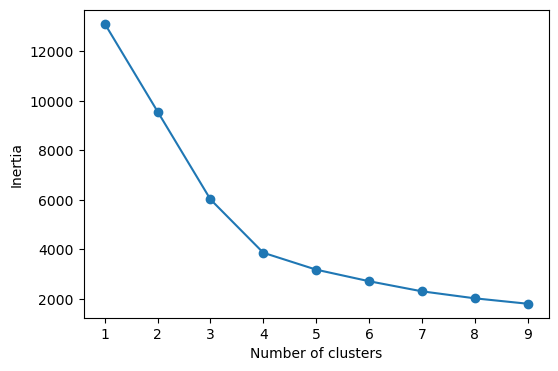

In [15]:
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':sse})
plt.figure(figsize=(6,4 ))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [16]:
# From the elbow method, we see that the optimal number of cluster is 4 clusters
kmeans = KMeans(n_clusters = 4, n_init=10)
kmeans.fit(features)
print(f"The silhouette score is: {silhouette_score(features, kmeans.labels_, metric='euclidean')}")

The silhouette score is: 0.4697675293516605


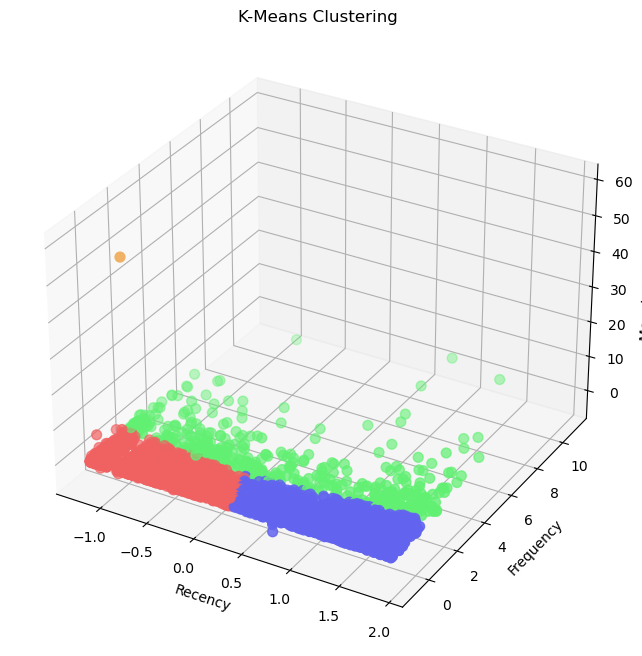

In [17]:
custom_colors = [red, blue, orange, green]
cmap = ListedColormap(custom_colors)

labels = kmeans.labels_
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features['recency'], features['frequency'], features['monetary_value'], c=labels, cmap=cmap, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('K-Means Clustering')

plt.show()

From the above graph, we see that there is an outlier that itself forms a class. We now remove the outliers.

In [18]:
from scipy import stats

# Remove the outliers
z_scores = stats.zscore(features)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
cleaned_features = features[filtered_entries]

print(f"The size of the cleaned features: {cleaned_features.shape}")

The size of the cleaned features: (4287, 3)


In [19]:
sse = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, n_init=10)
    kmeans.fit(cleaned_features)
    sse.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

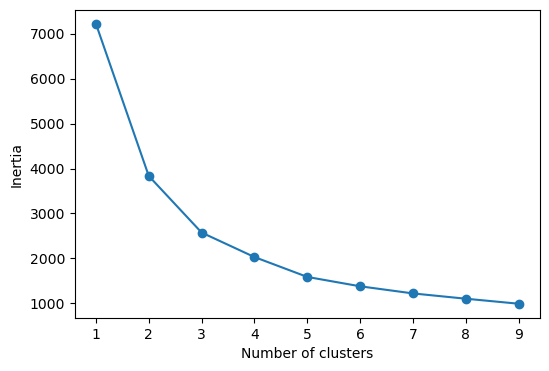

In [20]:
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':sse})
plt.figure(figsize=(6,4))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [21]:
kmeans = KMeans(n_clusters = 3, n_init=10)
kmeans.fit(cleaned_features)
print(f"The silhouette score is: {silhouette_score(cleaned_features, kmeans.labels_, metric='euclidean')}")

The silhouette score is: 0.4723099914197541


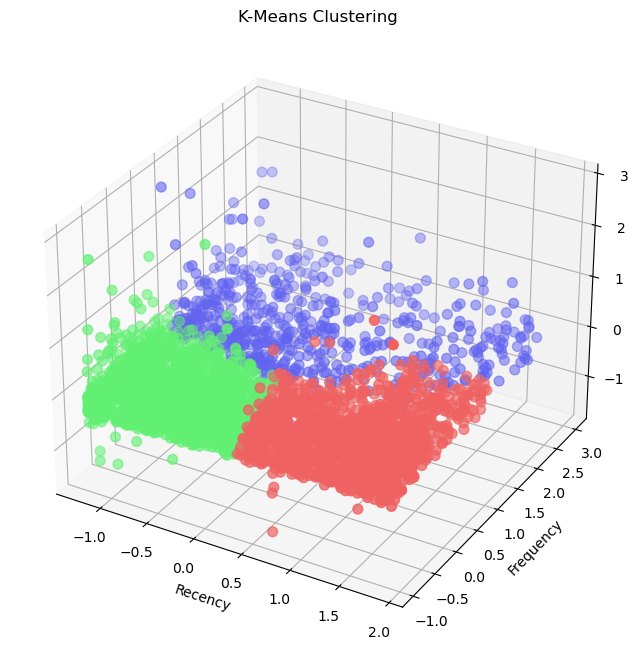

In [22]:
custom_colors = [blue, red, green]
cmap = ListedColormap(custom_colors)

labels = kmeans.labels_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(cleaned_features['recency'], cleaned_features['frequency'], cleaned_features['monetary_value'], c=labels, cmap=cmap, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('K-Means Clustering')

plt.show()

## Hierarchical Clustering

In [23]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

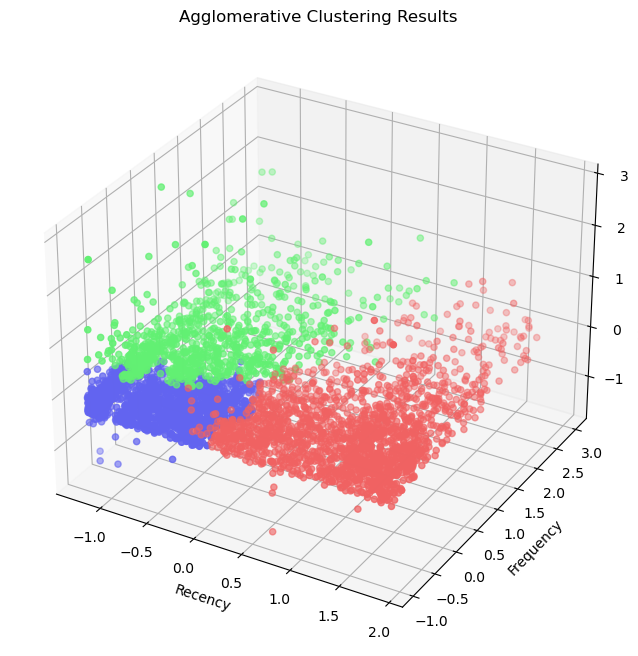

In [24]:
model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters = model.fit_predict(cleaned_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

color = [red, green, blue]


for cluster_label in np.unique(clusters):
    cluster_points = cleaned_features[clusters == cluster_label]
    ax.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], cluster_points.iloc[:, 2], c=color[cluster_label])

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary value')
ax.set_title('Agglomerative Clustering Results')
plt.show()

In [26]:
# Compute the Silhouette score
silhouette_avg = silhouette_score(cleaned_features, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3724629958331841


## Gaussian mixture clustering

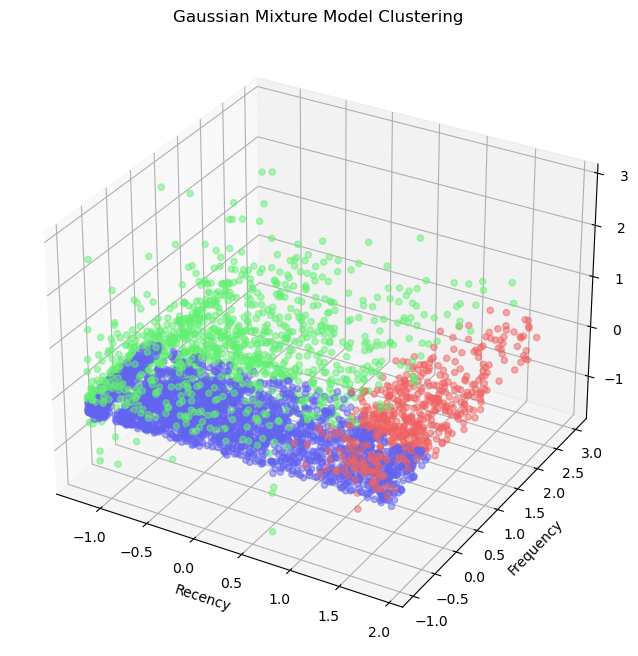

In [27]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Assuming your data is stored in a variable called 'data'
# data.shape should be (4000, 3)
# If not, you might need to adjust accordingly

# Assuming 'data' is a NumPy array
gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(cleaned_features)
custom_colors = [blue, green, red]
cmap = ListedColormap(custom_colors)

# Visualize the clusters in 3D (assuming 3 features)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cleaned_features.iloc[:, 0], cleaned_features.iloc[:, 1], cleaned_features.iloc[:, 2], c=clusters, cmap=cmap, alpha=0.5)
ax.set_title('Gaussian Mixture Model Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary value')
plt.show()

In [28]:
# Compute the Silhouette score
silhouette_avg = silhouette_score(cleaned_features, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.1773901481114778


## BIRCH clustering model

In [29]:
from sklearn.cluster import Birch

In [30]:
birch_model = Birch(n_clusters=None) 

birch_model.fit(cleaned_features)

cluster_labels = birch_model.predict(cleaned_features)

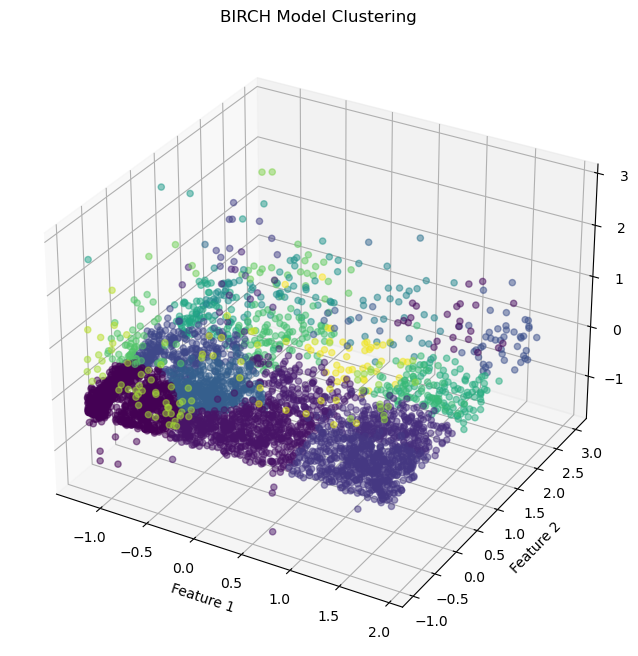

In [31]:
custom_colors = [blue, red, green]
cmap = ListedColormap(custom_colors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cleaned_features.iloc[:, 0], cleaned_features.iloc[:, 1], cleaned_features.iloc[:, 2], c=cluster_labels, cmap="viridis", alpha=0.5)
ax.set_title('BIRCH Model Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

In [32]:
print(f"There are a total of {len(np.unique(cluster_labels))} clusters")

There are a total of 38 clusters


In [33]:
birch_model = Birch(n_clusters=4) 

birch_model.fit(cleaned_features)

cluster_labels = birch_model.predict(cleaned_features)

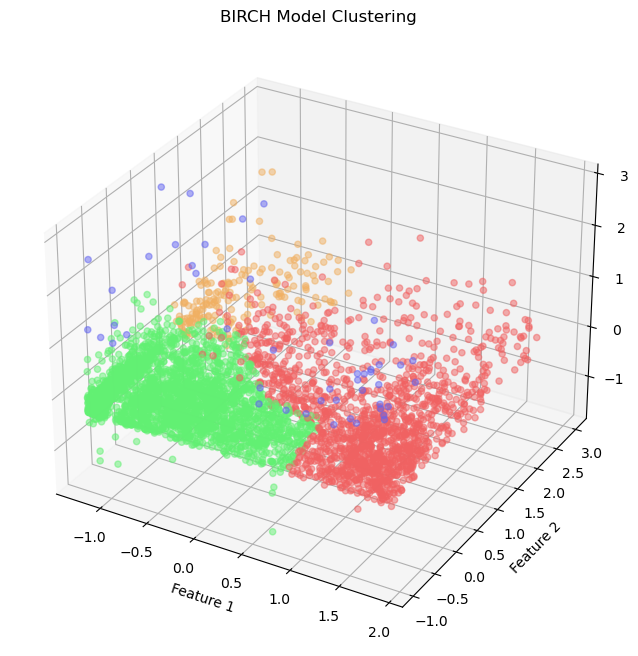

In [34]:
custom_colors = [blue, red, green, orange]
cmap = ListedColormap(custom_colors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cleaned_features.iloc[:, 0], cleaned_features.iloc[:, 1], cleaned_features.iloc[:, 2], c=cluster_labels, cmap=cmap, alpha=0.5)
ax.set_title('BIRCH Model Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

In [35]:
# Compute the Silhouette score
silhouette_avg = silhouette_score(cleaned_features, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.4024760840210064


In [36]:
cleaned_features

,recency,frequency,monetary_value
1,-1.196993,0.365177,0.240981
2,-1.120960,-0.249321,0.381462
3,1.751405,2.208668,1.052594
4,-0.715450,-0.249321,-0.051911
5,-0.597176,-0.337106,-0.081326
...,...,...,...
4367,-0.436661,-0.556569,-0.171276
4368,0.382807,-0.688247,-0.248715
4369,0.839007,-0.688247,-0.233666
4370,-0.943549,1.506386,-0.227271


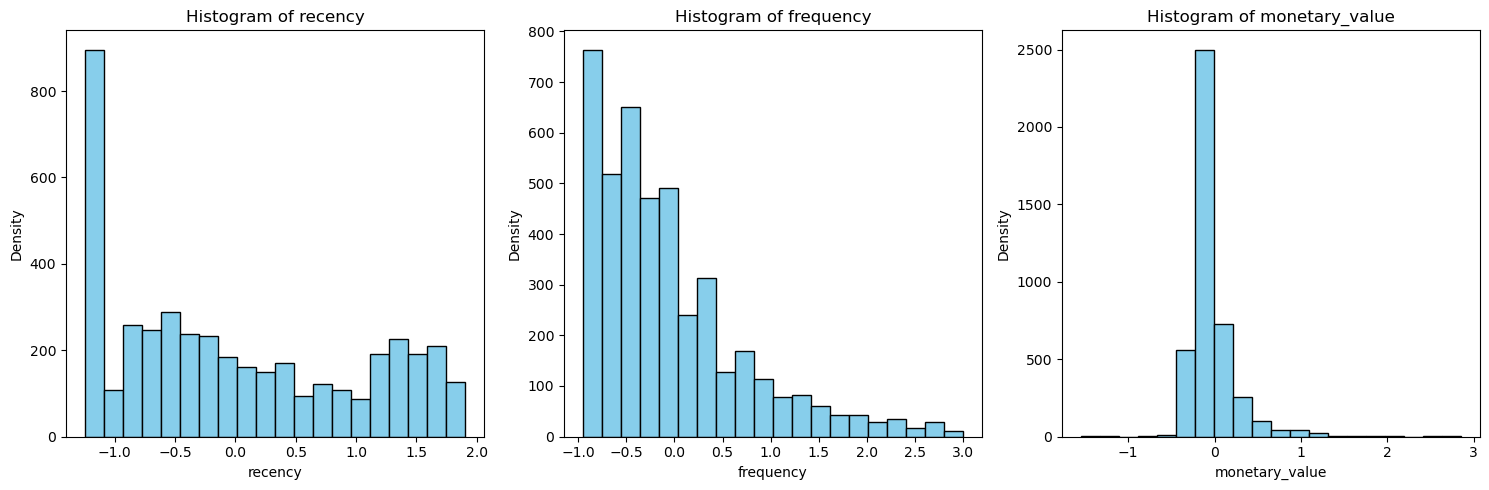

In [38]:
# Get the column names (feature names)
feature_names = cleaned_features.columns

# Create subplots for each feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms for each feature
for i, feature in enumerate(feature_names):
    axes[i].hist(cleaned_features[feature], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()